In [10]:
import pandas as pd
import re

In [11]:
unprocessed = pd.read_csv("../data/curated/input_df.csv")

In [12]:
unprocessed

,Rent_Price,Bedrooms,Bathrooms,Parking,Property_Type,Street,Suburb,Postcode,Distance_to_Nearest_Station_km,CountOfSchool,Cleaned_Text,Sentiment,Cleaned_HLTokens,Dominant_Topic,Dominant_Topic_Label,negative_class,positive_class
0,580.0,2,2,1,Apartment / Unit / Flat,304/373-377 Burwood Highway,Burwood,3125,3.372020,31,extremely stylish bedroom apartment available ...,0.240741,"['convenience', 'comfort']",0,Family Homes in Prime Locations,0.0,1.0
1,590.0,4,1,2,House,17 Brooks Street,Fawkner,3060,1.742835,11,welcome brooks street charming suburb fawkner ...,0.535000,"['home', 'sweet', 'home']",3,Stunning Furnished Apartments/Townhouses,0.0,1.0
2,580.0,3,2,1,House,37 Genesis Drive,Epping,3076,5.423585,17,apply click touch enquire link sent register i...,0.377778,"['convenient', 'family', 'home']",3,Stunning Furnished Apartments/Townhouses,0.0,1.0
3,575.0,2,1,2,Apartment / Unit / Flat,1/30 Park Street,Moonee Ponds,3039,0.562879,37,book inspection online save time view tour app...,0.535000,"['park', 'street', 'prestige']",2,"Modern, Low-Maintenance Apartments",0.0,1.0
4,850.0,4,3,2,House,343 Dromana Parade,Safety Beach,3936,20.690771,16,stunning beachside double story residence offe...,0.246032,"['location', 'location', 'location']",3,Stunning Furnished Apartments/Townhouses,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5519,550.0,2,1,2,Apartment / Unit / Flat,8 O'Farrell Place,Geelong,3220,48.876688,34,impeccably located secure wonderful opportunit...,0.481389,"['architecturally', 'designed', 'apartment', '...",1,"Beautiful, Convenient Family Homes",0.0,1.0
5520,450.0,2,1,1,Apartment / Unit / Flat,2/32 Acheron Avenue,Reservoir,3073,1.335725,18,nice bedroom unit ideally located great locati...,0.359821,"['great', 'location']",3,Stunning Furnished Apartments/Townhouses,0.0,1.0
5521,500.0,1,1,1,Apartment / Unit / Flat,1105/20 Wardens Walk,Coburg,3058,0.789010,18,weeks free rent welcome pace coburg located km...,0.268415,"['weeks', 'free', 'rent', 'brand', 'new', 'bed...",4,Central Units for Lease,0.0,1.0
5522,500.0,2,1,2,Apartment / Unit / Flat,4A Brian Street,Fawkner,3060,1.314401,11,register inspection start application scan qr ...,0.216667,"['simply', 'charming', 'low', 'maintenance', '...",3,Stunning Furnished Apartments/Townhouses,0.0,1.0


In [13]:
pattern = pattern = r'(?:\d+[A-Za-z]?\/?)?\d+[A-Za-z]?\s+([A-Za-z\s\'\-]+)'
unprocessed['Street_Name'] = unprocessed['Street'].str.extract(pattern)
unprocessed = unprocessed[['Rent_Price', 'Bedrooms', 'Bathrooms', 'Parking', 'Property_Type',
        'Suburb', 'Postcode', 'Distance_to_Nearest_Station_km',
       'CountOfSchool', 'Cleaned_Text', 'Sentiment', 'Cleaned_HLTokens',
       'Dominant_Topic', 'Dominant_Topic_Label', 'negative_class',
       'positive_class', 'Street_Name']]

In [14]:
unprocessed.columns

Index(['Rent_Price', 'Bedrooms', 'Bathrooms', 'Parking', 'Property_Type',
       'Suburb', 'Postcode', 'Distance_to_Nearest_Station_km', 'CountOfSchool',
       'Cleaned_Text', 'Sentiment', 'Cleaned_HLTokens', 'Dominant_Topic',
       'Dominant_Topic_Label', 'negative_class', 'positive_class',
       'Street_Name'],
      dtype='object')

! should we creata e a feature describing the level of school ,for each suburb take average of 0 fpr primary, 1 for sec, 2 for high school then averag it in suburb. 
! using the gender distribution from abs sa2, then check the singlesex school

- Nominal: 'Property_Type', 'Suburb', 'Postcode', 'Dominant_Topic'(HL), 'Street_Name'
- Numerical continuous: 'Sentiment'(PD), 
- Numerical discrete: 'Bedrooms', 'Bathrooms', 'Parking', 'CountOfSchool', 'negative_class'(PD), 'positive_class'(PD)
- TextData: 'Cleaned_text' -> property description, 'Cleaned_HLTokens'-> Headline

## Encoding

In [15]:
processed = unprocessed.copy()
numerical = ['Bedrooms', 'Bathrooms', 'Parking', 'CountOfSchool', 'negative_class', 'positive_class','Sentiment', 'Rent_Price']
nominal = ['Property_Type', 'Suburb', 'Postcode', 'Dominant_Topic', 'Street_Name']
text = ['Cleaned_text', 'Cleaned_HLTokens']
processed = unprocessed[numerical]

In [16]:
from sklearn.feature_extraction import FeatureHasher

one_hot_property_type = pd.get_dummies(unprocessed['Property_Type'], prefix='Property_Type').astype(int)
processed = pd.concat([processed, one_hot_property_type], axis=1)

mean_target_per_suburb = unprocessed.groupby('Suburb')['Rent_Price'].mean()
unprocessed['Suburb_encoded'] = unprocessed['Suburb'].map(mean_target_per_suburb)
processed['Suburb_encoded'] = unprocessed['Suburb_encoded']

one_hot_dominant_topic = pd.get_dummies(unprocessed['Dominant_Topic'], prefix='Dominant_Topic').astype(int)
processed = pd.concat([processed, one_hot_dominant_topic], axis=1)

unprocessed['Street_Name'] = unprocessed['Street_Name'].apply(lambda x: [str(x)])
hasher = FeatureHasher(input_type='string', n_features=10)
hashed_street_name = hasher.transform(unprocessed['Street_Name'])
hashed_street_df = pd.DataFrame(hashed_street_name.toarray(), columns=[f"hash_{i}" for i in range(10)])

processed = pd.concat([processed, hashed_street_df], axis=1)


In [17]:
processed

,Bedrooms,Bathrooms,Parking,CountOfSchool,negative_class,positive_class,Sentiment,Rent_Price,Property_Type_Acreage / Semi-Rural,Property_Type_Apartment / Unit / Flat,...,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9
0,2,2,1,31,0.0,1.0,0.240741,580.0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,1,2,11,0.0,1.0,0.535000,590.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
2,3,2,1,17,0.0,1.0,0.377778,580.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,2,1,2,37,0.0,1.0,0.535000,575.0,0,1,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,3,2,16,0.0,1.0,0.246032,850.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5519,2,1,2,34,0.0,1.0,0.481389,550.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5520,2,1,1,18,0.0,1.0,0.359821,450.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5521,1,1,1,18,0.0,1.0,0.268415,500.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5522,2,1,2,11,0.0,1.0,0.216667,500.0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
processed['Parking'] = processed['Parking'].replace('−', '0')
processed['Parking'] = pd.to_numeric(processed['Parking'])


In [19]:
X = processed.drop("Rent_Price", axis = 1)
y = processed['Rent_Price']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100) 

headline_tfidf = tfidf.fit_transform(unprocessed['Cleaned_HLTokens'])

tfidf_df = pd.DataFrame(headline_tfidf.toarray(), columns=tfidf.get_feature_names_out())

X = pd.concat([X, tfidf_df], axis=1)


In [21]:
X

,Bedrooms,Bathrooms,Parking,CountOfSchool,negative_class,positive_class,Sentiment,Property_Type_Acreage / Semi-Rural,Property_Type_Apartment / Unit / Flat,Property_Type_Block of Units,...,study,stunning,style,stylish,townhouse,unit,updated,view,views,walk
0,2,2,1,31,0.0,1.0,0.240741,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,4,1,2,11,0.0,1.0,0.535000,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,2,1,17,0.0,1.0,0.377778,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,2,1,2,37,0.0,1.0,0.535000,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,4,3,2,16,0.0,1.0,0.246032,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5519,2,1,2,34,0.0,1.0,0.481389,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5520,2,1,1,18,0.0,1.0,0.359821,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5521,1,1,1,18,0.0,1.0,0.268415,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5522,2,1,2,11,0.0,1.0,0.216667,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.436836,0.0,0.0,0.0,0.0


In [22]:
processed.columns

Index(['Bedrooms', 'Bathrooms', 'Parking', 'CountOfSchool', 'negative_class',
       'positive_class', 'Sentiment', 'Rent_Price',
       'Property_Type_Acreage / Semi-Rural',
       'Property_Type_Apartment / Unit / Flat', 'Property_Type_Block of Units',
       'Property_Type_House', 'Property_Type_New Apartments / Off the Plan',
       'Property_Type_New House & Land', 'Property_Type_Semi-Detached',
       'Property_Type_Studio', 'Property_Type_Terrace',
       'Property_Type_Townhouse', 'Property_Type_Villa', 'Suburb_encoded',
       'Dominant_Topic_0', 'Dominant_Topic_1', 'Dominant_Topic_2',
       'Dominant_Topic_3', 'Dominant_Topic_4', 'hash_0', 'hash_1', 'hash_2',
       'hash_3', 'hash_4', 'hash_5', 'hash_6', 'hash_7', 'hash_8', 'hash_9'],
      dtype='object')

In [23]:
print(processed['Bedrooms'].unique())
print(processed['Bathrooms'].unique())
print(processed['Parking'].unique())
print(processed['CountOfSchool'].unique())
print(processed['Rent_Price'].unique())

[2 4 3 1 5 6 0 7 9 8]
[ 2  1  3  4  0  9  5 12]
[ 1  2  0  3  4  5  6  7 20  8 11 12]
[31 11 17 37 16 29 50 19 18 24 26 20  7 27  9 30 35 34 15 39 33 23 32 36
 41 47 22 21 28 10 14 13 52 40  8 43 25 12 51 38 44 69 56 42 58 62 49 55
 74 64 48 54]
[ 580.    590.    575.    850.    430.    595.    390.    460.    520.
  480.    760.    550.    795.    270.    525.    610.    335.    740.
  660.    500.    695.    700.    600.    680.    720.    650.    490.
  565.    570.    470.    895.    380.    750.    840.    530.    780.
  440.    620.    535.    375.    540.   1000.    280.    475.    630.
  360.    310.    420.    925.    400.    845.    450.    890.    510.
  548.    725.    560.    350.    985.    435.    765.    920.    665.
  880.    785.    675.    300.    950.    980.    670.    800.    410.
  515.    900.    684.    585.    495.    290.    330.    730.    635.
  395.    640.    320.    230.    770.    425.    820.    690.    645.
  370.    790.    340.    260.    830.    54

In [24]:

columns_with_dash = X.columns[(X == '-').any()].tolist()

print("Columns containing '-':", columns_with_dash)

rows_with_dash = X[X.isin(['-']).any(axis=1)]

print("Rows containing '-':")
print(rows_with_dash)


Columns containing '-': []
Rows containing '-':
Empty DataFrame
Columns: [Bedrooms, Bathrooms, Parking, CountOfSchool, negative_class, positive_class, Sentiment, Property_Type_Acreage / Semi-Rural, Property_Type_Apartment / Unit / Flat, Property_Type_Block of Units, Property_Type_House, Property_Type_New Apartments / Off the Plan, Property_Type_New House & Land, Property_Type_Semi-Detached, Property_Type_Studio, Property_Type_Terrace, Property_Type_Townhouse, Property_Type_Villa, Suburb_encoded, Dominant_Topic_0, Dominant_Topic_1, Dominant_Topic_2, Dominant_Topic_3, Dominant_Topic_4, hash_0, hash_1, hash_2, hash_3, hash_4, hash_5, hash_6, hash_7, hash_8, hash_9, accommodation, affordable, amenities, apartment, apartments, application, available, bathroom, beach, beautiful, beautifully, bed, bedroom, bedrooms, best, block, brand, bright, central, charm, charming, city, close, comfort, comfortable, contemporary, convenience, convenient, court, courtyard, delight, easy, estate, family, fi

In [25]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

mi = mutual_info_regression(X, y)

mi


array([1.69761233e-01, 1.57477261e-01, 6.04654202e-02, 6.89158667e-02,
       2.99994196e-03, 1.63310791e-02, 5.38995718e-02, 1.45274555e-03,
       5.54504300e-02, 0.00000000e+00, 2.21990984e-02, 0.00000000e+00,
       1.00024938e-02, 0.00000000e+00, 1.88159573e-02, 0.00000000e+00,
       2.24805535e-02, 6.80700078e-03, 3.17156027e-01, 0.00000000e+00,
       8.74443931e-03, 0.00000000e+00, 0.00000000e+00, 1.74979160e-02,
       1.07115576e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.99686893e-02, 0.00000000e+00, 3.79835429e-03, 0.00000000e+00,
       2.01545527e-02, 6.20797060e-03, 2.50435670e-02, 4.95475129e-03,
       0.00000000e+00, 0.00000000e+00, 1.11483550e-02, 2.88487265e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.13334781e-02, 0.00000000e+00, 1.12301161e-02, 0.00000000e+00,
       3.52310890e-04, 1.01645408e-02, 9.93855287e-03, 4.30964158e-03,
       0.00000000e+00, 2.49278999e-04, 0.00000000e+00, 0.00000000e+00,
      

In [26]:
mi_sorted = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print(mi_sorted)

Suburb_encoded    0.317156
Bedrooms          0.169761
Bathrooms         0.157477
CountOfSchool     0.068916
Parking           0.060465
                    ...   
month             0.000000
bed               0.000000
furnished         0.000000
beach             0.000000
beautiful         0.000000
Length: 134, dtype: float64


In [27]:
selector = SelectKBest(mutual_info_regression, k=100)
X_filtered = selector.fit_transform(X, y)

selected_feature_names = X.columns[selector.get_support()]

In [28]:
X_filtered

array([[2., 2., 1., ..., 0., 0., 0.],
       [4., 1., 2., ..., 0., 0., 0.],
       [3., 2., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [2., 1., 2., ..., 0., 0., 0.],
       [3., 1., 3., ..., 0., 0., 0.]])

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(model, n_features_to_select=20, step=10)
X_wrapper_selected = rfe.fit_transform(X_filtered, y)

selected_rfe_features = selected_feature_names[rfe.get_support()]


In [30]:
X_wrapper_selected

array([[2.        , 0.24074074, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.535     , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [2.        , 0.37777778, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.26841492, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.21666667, 0.        , ..., 0.43683649, 0.        ,
        0.        ],
       [1.        , 0.13809524, 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [31]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_wrapper_selected, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 18660.140255832805
R-squared (R2): 0.2299254116283319


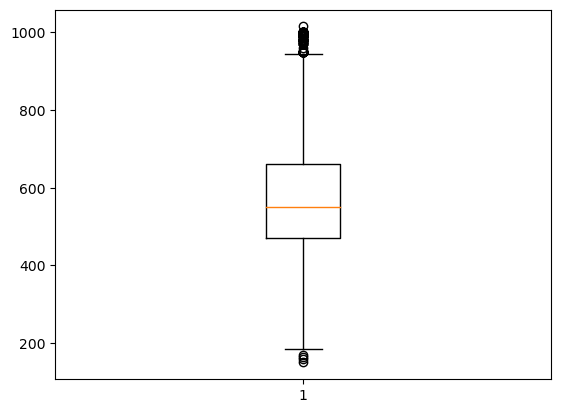

In [32]:
import matplotlib.pyplot as plt
plt.boxplot(y)
plt.show()


In [33]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 21013.56559110299
R-squared (R2): 0.13280325598134268


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 16199.195653948977
R-squared (R2): 0.33148471800647084
